# Feature Analysis and PCA of SABR Parameters

The SABR Model parametrises volatility data across many tenors and expiries with just 4 parameters: `alpha`, `beta`, `rho`, `nu`. Could I use Principal Component Analysis to identify correlations between these parameters, and potentially combine parameters to reduce the dimensionality of the model?

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

# Load the SABR parameters matrix
matrix = pd.read_csv('sabr_parameters.csv')

## Feature Scaling

In [3]:
scaled = pd.DataFrame()
currencies = set(matrix['currency'].values)
tenors = [0.25, 0.5, 0.75, 1, 2, 3]

for currency in currencies:
    for tenor in tenors:
        smiles = matrix[(matrix['currency'] == currency) & (matrix['tenor'] == tenor)]
        if smiles.empty:
            continue
            
        dates = list(smiles['date'])
        scaler = StandardScaler() # Standardise to mean 0 s.d. 1
        
        # Scale only the SABR parameters and forward rate
        features_to_scale = smiles[['alpha', 'rho', 'nu', 'fwd']]
        scaled_features = scaler.fit_transform(features_to_scale)
        
        new = pd.DataFrame(scaled_features, columns=['alpha', 'rho', 'nu', 'fwd'])
        new['tenor'] = tenor
        new['date'] = dates
        new['currency'] = currency
        
        scaled = pd.concat([scaled, new], ignore_index=True)

## Check for Covariance

In [4]:
features = ['alpha', 'rho', 'nu', 'fwd']
corr = scaled[features].corr()
corr.style

,alpha,rho,nu,fwd
alpha,1.000000,-0.046314,-0.551962,0.033893
rho,-0.046314,1.000000,0.037769,0.293203
nu,-0.551962,0.037769,1.000000,-0.024479
fwd,0.033893,0.293203,-0.024479,1.000000


The only variables with statistically significant correlation are alpha and nu

In [5]:
#Visualisation of the correlation matrix
features = ['alpha', 'rho', 'nu', 'fwd']

fig = px.scatter_matrix(
    scaled,
    dimensions=features,
    color='date',
    title="Pairwise Feature Relationships"
)
fig.update_traces(diagonal_visible=False)
fig.show()

## Principal Component Analysis (PCA)

Since `alpha` and `nu` are correlated, maybe I can reduce the dimensionality of the model using PCA.

In [6]:
features = ['alpha', 'nu']
pca = PCA()
components = pca.fit_transform(scaled[features])

# Create labels showing variance explained
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

# Create DataFrame for plotting
pca_df = pd.DataFrame(components, columns=['PC1', 'PC2'])
pca_df['date'] = scaled['date']
pca_df['currency'] = scaled['currency']
pca_df['tenor'] = scaled['tenor']

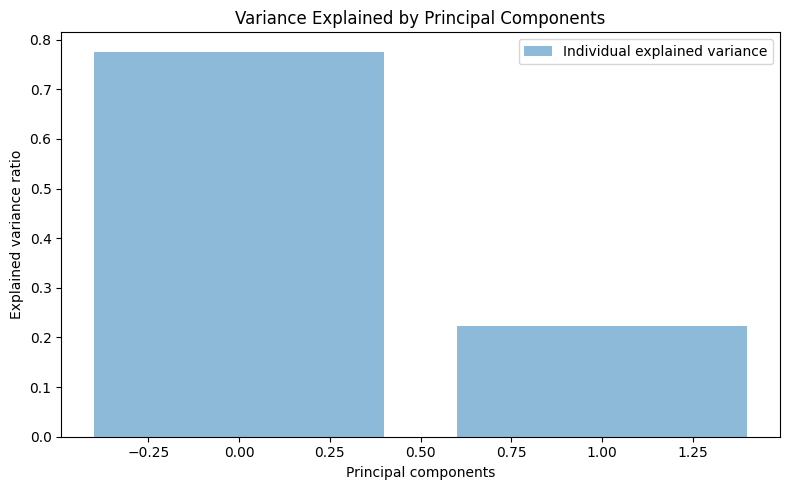

In [7]:
plt.figure(figsize=(8, 5))
plt.bar(range(len(pca.explained_variance_ratio_)), 
        pca.explained_variance_ratio_,
        alpha=0.5,
        align='center',
        label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Variance Explained by Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [8]:
fig = px.scatter(
    pca_df, 
    x='PC1', 
    y='PC2',
    color='date',
    hover_data=['currency', 'tenor'],
    title="PCA of Alpha and Nu Parameters"
)
fig.update_layout(
    xaxis_title=labels['0'],
    yaxis_title=labels['1']
)
fig.show()

The new PCA components have no significance to price or volatility calculations, and there is no observable trend across trading days. Due to the low correlation between the other parameters, further dimension reduction is probably not possible. 